In [1]:
import sqlite3
import numpy as np
import pandas as pd

conn = sqlite3.connect('data/nyc_taxi.db')

# Ensuring taxi pickup and dropoff are in NYC

In [2]:
nyc_lon_bounds = [-74.03, -73.75]
nyc_lat_bounds = [40.6, 40.88]

query = """
    SELECT *
    FROM taxi
    WHERE  pickup_lon BETWEEN -74.03 AND -73.75
        AND  dropoff_lon BETWEEN -74.03 AND -73.75
        AND pickup_lat  BETWEEN 40.6 AND 40.88
        AND  dropoff_lat BETWEEN 40.6 AND 40.88
    """
        

nyc_taxi = pd.read_sql(query, conn)

nyc_taxi = nyc_taxi.query("60 <= duration <= 3600")\
                     .query("distance > 0")\
                     .query("(distance / (duration / 3600)) <= 100")

print(nyc_taxi.shape)

(96445, 9)


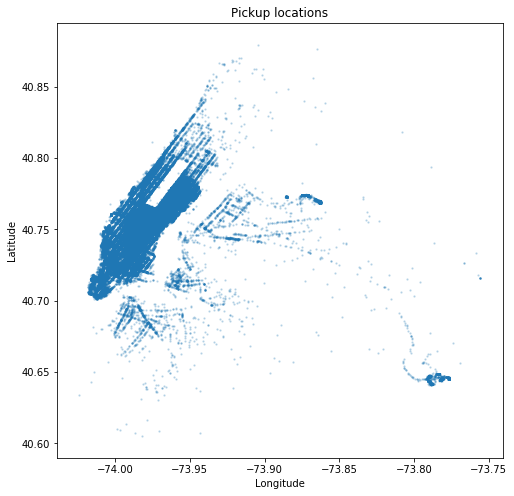

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def pickup_scatter(t):
    plt.scatter(t.pickup_lon, t.pickup_lat, s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(nyc_taxi)

# Restricting taxi rides to within the Manhattan geo-border

In [4]:
manhattan_polygon = pd.read_csv('data/manhattan_border.csv')

coordinates = np.hstack((nyc_taxi[['pickup_lat', 'pickup_lon']].values,
                    nyc_taxi[['dropoff_lat', 'dropoff_lon']].values))

def boundry_indicator(taxi_ride):
    pickup = taxi_ride[0], taxi_ride[1]
    dropoff = taxi_ride[2], taxi_ride[3]
    
    def coordinate_check(x, y):
        check = False
        polyX , polyY = list(manhattan_polygon.lat), list(manhattan_polygon.lon)
        
        i, j = 0, len(polyX) - 1   
        for i in range(len(polyX)):
            if ((polyY[i] < y) & (polyY[j] >= y)) or ((polyY[j] < y) & (polyY[i] >= y)):
                if (polyX[i] + (y - polyY[i]) / (polyY[j] - polyY[i]) * (polyX[j] - polyX[i]) < x):
                    check = not check
            j = i
            i +=1
        return check
        
    if coordinate_check(pickup[0], pickup[1]) == True:
        return coordinate_check(dropoff[0], dropoff[1])
    else: False

nyc_taxi['manhattanInd'] = [boundry_indicator(taxi_ride) for taxi_ride in coordinates]

manhattan_taxi = nyc_taxi.query("manhattanInd == True").drop(['manhattanInd'], axis=1)
manhattan_taxi.shape

(82800, 9)

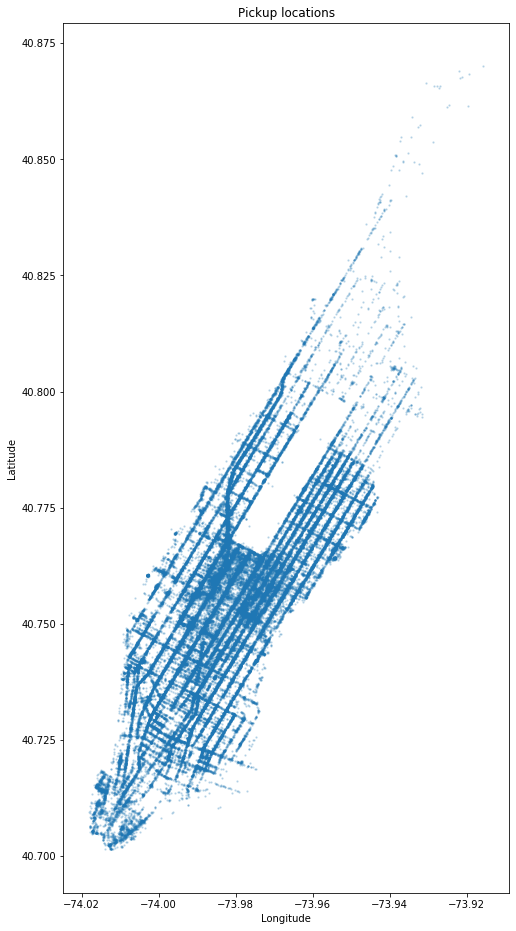

In [5]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

# Filtering out taxi data affected by historic blizard

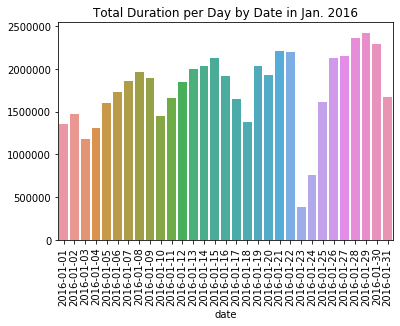

In [6]:
manhattan_taxi['date'] = pd.to_datetime(manhattan_taxi.pickup_datetime).apply(lambda x: x.date())

blizzard = manhattan_taxi[(manhattan_taxi.date.apply(lambda x: x.month) == 1) & 
                          (manhattan_taxi.date.apply(lambda x: x.year) == 2016)]

ax = sns.barplot(x = blizzard.groupby('date').duration.sum().index,
                 y = blizzard.groupby('date').duration.sum().values , data = blizzard)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Total Duration per Day by Date in Jan. 2016');

In [7]:
import calendar
import re

pat = '  [1-3]|18 | 23| 24|25 |26 '

print('Typical dates:\n')
print(re.sub(pat, '   ', calendar.month(2016, 1)))

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



In [8]:
from datetime import date

atypical_dates = [1, 2, 3, 18, 23, 24, 25, 26]

manhattan_taxi = manhattan_taxi[manhattan_taxi.date.isin([date(2016, 1, n) for n in range(1, 32) 
                                                         if n not in atypical_dates])]
manhattan_taxi.shape

(67101, 10)

# Clustering taxi pickup location

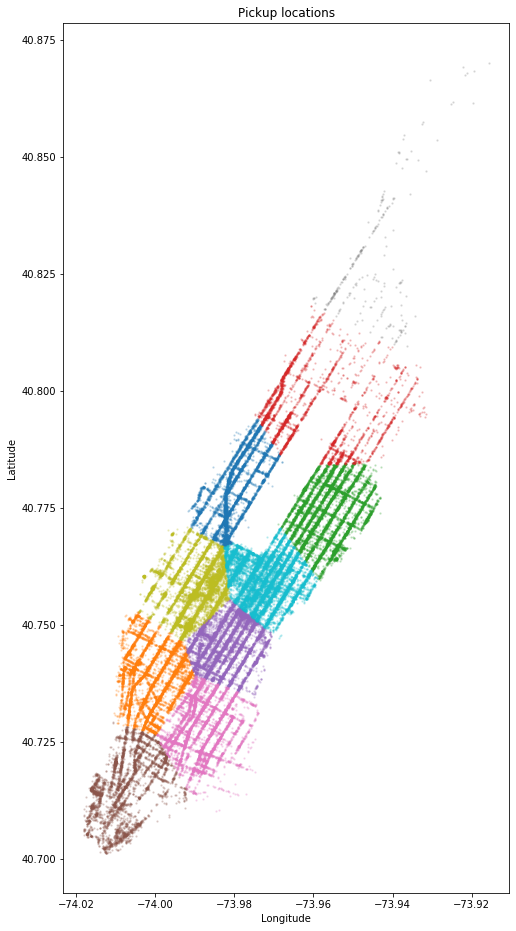

In [9]:
from sklearn.cluster import MiniBatchKMeans

coordinates = np.vstack((manhattan_taxi[['pickup_lat', 'pickup_lon']].values,
                   manhattan_taxi[['dropoff_lat', 'dropoff_lon']].values))

sample_ind = np.random.permutation(len(coordinates))[:500000]
kmeans = MiniBatchKMeans(n_clusters = 10, batch_size = 10000).fit(coordinates[sample_ind])

manhattan_taxi['pickup_cluster'] = kmeans.predict(manhattan_taxi[['pickup_lat', 'pickup_lon']])

plt.figure(figsize=(8, 16))
for i in np.arange(0,10):
    pickup_scatter(manhattan_taxi[manhattan_taxi.pickup_cluster == i])

# PCA on taxi pickup locations

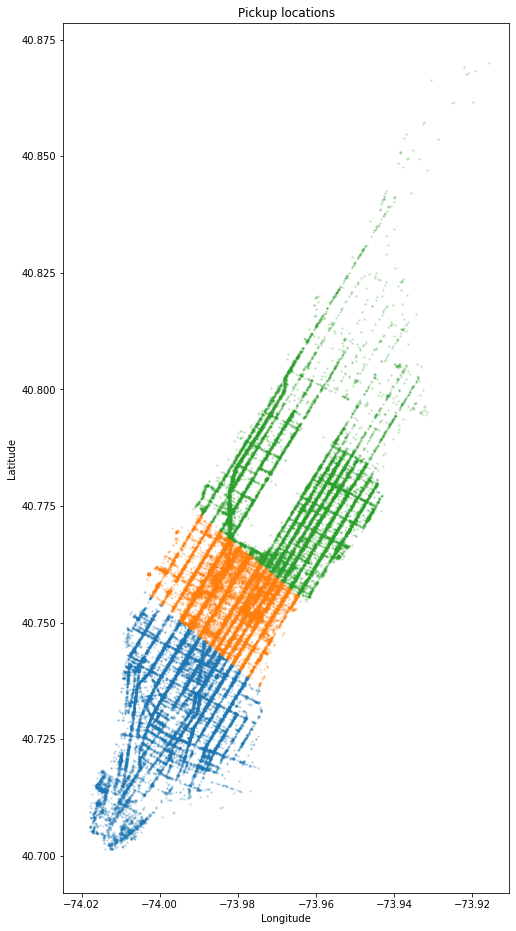

In [10]:
def add_pca_region(t):
    D = t[['pickup_lon', 'pickup_lat']]
    pca_n, pca_means = len(D), np.mean(D)
    X = (D - pca_means) / np.sqrt(pca_n) 
    u, s, vt = np.linalg.svd(X, full_matrices = False)
    first_pc = X @ vt.T[0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_pca_region(manhattan_taxi)

plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(manhattan_taxi[manhattan_taxi.region == i])

# Augmenting additional features

In [11]:
pickup_time = pd.to_datetime(manhattan_taxi.pickup_datetime)

def speed(t):
    return t.distance / t.duration * 60 * 60

def augment(t):
    t.loc[:, 'hour'] = pickup_time.dt.hour
    t.loc[:, 'day'] = pickup_time.dt.weekday
    t.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    t['speed'] = speed(t)
    return t

manhattan_taxi = augment(manhattan_taxi)
manhattan_taxi.columns

Index(['pickup_datetime', 'dropoff_datetime', 'pickup_lon', 'pickup_lat',
       'dropoff_lon', 'dropoff_lat', 'passengers', 'distance', 'duration',
       'date', 'pickup_cluster', 'region', 'hour', 'day', 'weekend', 'speed'],
      dtype='object')

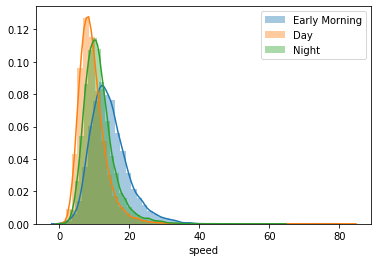

In [12]:
ax = sns.distplot(manhattan_taxi.query('hour <= 6').speed, label = 'Early Morning')
ax = sns.distplot(manhattan_taxi.query('6 < hour <= 18').speed, label = 'Day')
ax = sns.distplot(manhattan_taxi.query('18 < hour <= 24').speed, label = 'Night')
ax.legend();

manhattan_taxi['day_period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])

In [13]:
final_taxi = manhattan_taxi.copy()
final_taxi.shape

(67101, 17)

In [14]:
import pickle

def save(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
        
save(final_taxi, path = 'data/final_taxi.pkl')